In [14]:
import pandas as pd
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta

from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

logging.getLogger('matplotlib.font_manager').disabled = True



In [15]:
key_path = "/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)

# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 131, 127, 130, 143, 144, 145, 146]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'tenant type', 'age', 'building type', 'solar panels', 'heat pump', 'electric vehicle', 'electric water heating']

#print(extracted_df)

# Save extracted columns to a new Excel or CSV file if needed

#extracted_df.to_csv("extracted_columns.csv", index=False)

In [21]:

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

print(extracted_df)


      house-id tenant type                age  \
0        10015      Tenant    18-35 years old   
1        10030         NaN                NaN   
2        10135      Tenant    18-35 years old   
3        10207         NaN                NaN   
4        10219      Tenant  36 - 50 years old   
...        ...         ...                ...   
1495     75793       Owner  51 - 65 years old   
1496     75799       Owner  36 - 50 years old   
1497     75802      Tenant  51 - 65 years old   
1498     75808       Owner  36 - 50 years old   
1499     75820      Tenant  51 - 65 years old   

                                   building type solar panels heat pump  \
0                                 Terraced house          NaN       NaN   
1                                            NaN          NaN       NaN   
2     Flat in a building with more than 10 flats          NaN       NaN   
3                                            NaN          NaN       NaN   
4     Flat in a building with more t

In [17]:
pattern = "/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/SM_DATA_average_min/*CH*.csv"
file_paths = glob.glob(pattern)

print(f"Number of files found: {len(file_paths)}")

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

Number of files found: 1464
Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [18]:
train_data = data_3d

n_clusters = 7  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

0.300 --> 0.185 --> 0.179 --> 0.176 --> 0.175 --> 0.174 --> 0.174 --> 0.173 --> 0.173 --> 0.172 --> 0.171 --> 0.171 --> 0.170 --> 0.170 --> 0.170 --> 0.170 --> 0.170 --> 


In [19]:
# Initialize an empty list to store individual DataFrames for each cluster
cluster_dataframes = []

for cluster_idx in range(n_clusters):
    # Get all indices in this cluster
    cluster_indices = np.where(clusters_train == cluster_idx)[0]
    
    # Create a Polars DataFrame for the current cluster's indices
    cluster_df = pl.DataFrame({
        "cluster": pl.Series([cluster_idx + 1] * len(cluster_indices)),
        "index": pl.Series(cluster_indices)
    })
    
    # Append this cluster DataFrame to the list
    cluster_dataframes.append(cluster_df)

# Concatenate all cluster DataFrames into one
cluster_indices_df = pl.concat(cluster_dataframes)

# Print the DataFrame to verify
print("\nCluster Indices DataFrame:")
print(cluster_indices_df)


Cluster Indices DataFrame:
shape: (1_464, 2)
┌─────────┬───────┐
│ cluster ┆ index │
│ ---     ┆ ---   │
│ i64     ┆ i64   │
╞═════════╪═══════╡
│ 1       ┆ 1     │
│ 1       ┆ 2     │
│ 1       ┆ 4     │
│ 1       ┆ 5     │
│ 1       ┆ 6     │
│ …       ┆ …     │
│ 7       ┆ 1457  │
│ 7       ┆ 1458  │
│ 7       ┆ 1459  │
│ 7       ┆ 1461  │
│ 7       ┆ 1462  │
└─────────┴───────┘


In [29]:
# Convert filename_list items to strings if not already
house_ids = [str(h) for h in filename_list]

# Create Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1  # adjust if needed
})

extracted_pl_df = pl.from_pandas(extracted_df)

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

extracted_pl_df = extracted_pl_df.with_columns(
    pl.col("CH_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

# First join: attach survey columns
joined = result_df.join(
    extracted_pl_df.select([
        "ch_id_clean",
        "tenant type",
        "age",
        "building type",
        "solar panels",
        "heat pump",
        "electric vehicle",
        "electric water heating"
    ]),
    on="ch_id_clean",
    how="left"
)

# Second join: attach consumption
joined = joined.join(
    alle_mittelwerte_df.select(["ch_id_clean", "bruttolastgang_kwh_sum"]),
    on="ch_id_clean",
    how="left"
)

# Now select in the desired order
final_df = joined.select([
    "house_id",                # Column 0
    "bruttolastgang_kwh_sum",  # Column 1
    "cluster",                 # Column 2
    "tenant type",
    "age",
    "building type",
    "solar panels",
    "heat pump",
    "electric vehicle",
    "electric water heating"
])

print(final_df.head())

shape: (5, 10)
┌─────────────┬─────────────┬─────────┬────────┬───┬────────┬───────────┬─────────────┬────────────┐
│ house_id    ┆ bruttolastg ┆ cluster ┆ tenant ┆ … ┆ solar  ┆ heat pump ┆ electric    ┆ electric   │
│ ---         ┆ ang_kwh_sum ┆ ---     ┆ type   ┆   ┆ panels ┆ ---       ┆ vehicle     ┆ water      │
│ str         ┆ ---         ┆ i64     ┆ ---    ┆   ┆ ---    ┆ str       ┆ ---         ┆ heating    │
│             ┆ f64         ┆         ┆ str    ┆   ┆ str    ┆           ┆ str         ┆ ---        │
│             ┆             ┆         ┆        ┆   ┆        ┆           ┆             ┆ str        │
╞═════════════╪═════════════╪═════════╪════════╪═══╪════════╪═══════════╪═════════════╪════════════╡
│ CH101860123 ┆ 4790.208    ┆ 7       ┆ null   ┆ … ┆ null   ┆ null      ┆ EV          ┆ no         │
│ 45000000000 ┆             ┆         ┆        ┆   ┆        ┆           ┆             ┆ electric   │
│ 00000040…   ┆             ┆         ┆        ┆   ┆        ┆           ┆   

In [39]:
def categorize_consumption(value):
    if value < 5000:
        return "0-5 MWh"
    elif value < 10000:
        return "5-10 MWh"
    elif value < 15000:
        return "10-15 MWh"
    elif value < 20000:
        return "15-20 MWh"
    elif value < 25000:
        return "20-25 MWh"
    else:
        return "25+ MWh"

final_df = final_df.with_columns(
    pl.col("bruttolastgang_kwh_sum")
      .map_elements(categorize_consumption, return_dtype=pl.Utf8)
      .alias("consumption_category")
)

print(final_df.head())

shape: (5, 11)
┌────────────┬────────────┬─────────┬────────┬───┬───────────┬────────────┬────────────┬───────────┐
│ house_id   ┆ bruttolast ┆ cluster ┆ tenant ┆ … ┆ heat pump ┆ electric   ┆ electric   ┆ consumpti │
│ ---        ┆ gang_kwh_s ┆ ---     ┆ type   ┆   ┆ ---       ┆ vehicle    ┆ water      ┆ on_catego │
│ str        ┆ um         ┆ i64     ┆ ---    ┆   ┆ str       ┆ ---        ┆ heating    ┆ ry        │
│            ┆ ---        ┆         ┆ str    ┆   ┆           ┆ str        ┆ ---        ┆ ---       │
│            ┆ f64        ┆         ┆        ┆   ┆           ┆            ┆ str        ┆ str       │
╞════════════╪════════════╪═════════╪════════╪═══╪═══════════╪════════════╪════════════╪═══════════╡
│ CH10186012 ┆ 4790.208   ┆ 7       ┆ null   ┆ … ┆ null      ┆ EV         ┆ no         ┆ 0-5 MWh   │
│ 3450000000 ┆            ┆         ┆        ┆   ┆           ┆            ┆ electric   ┆           │
│ 0000000040 ┆            ┆         ┆        ┆   ┆           ┆            ┆ 

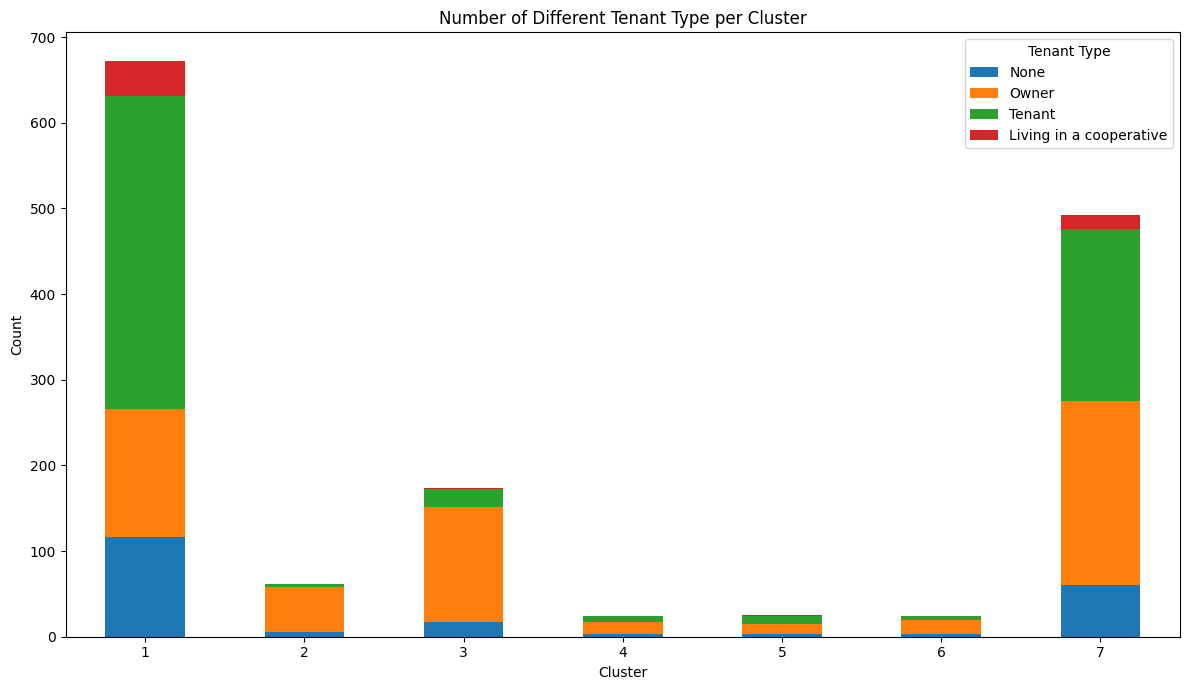

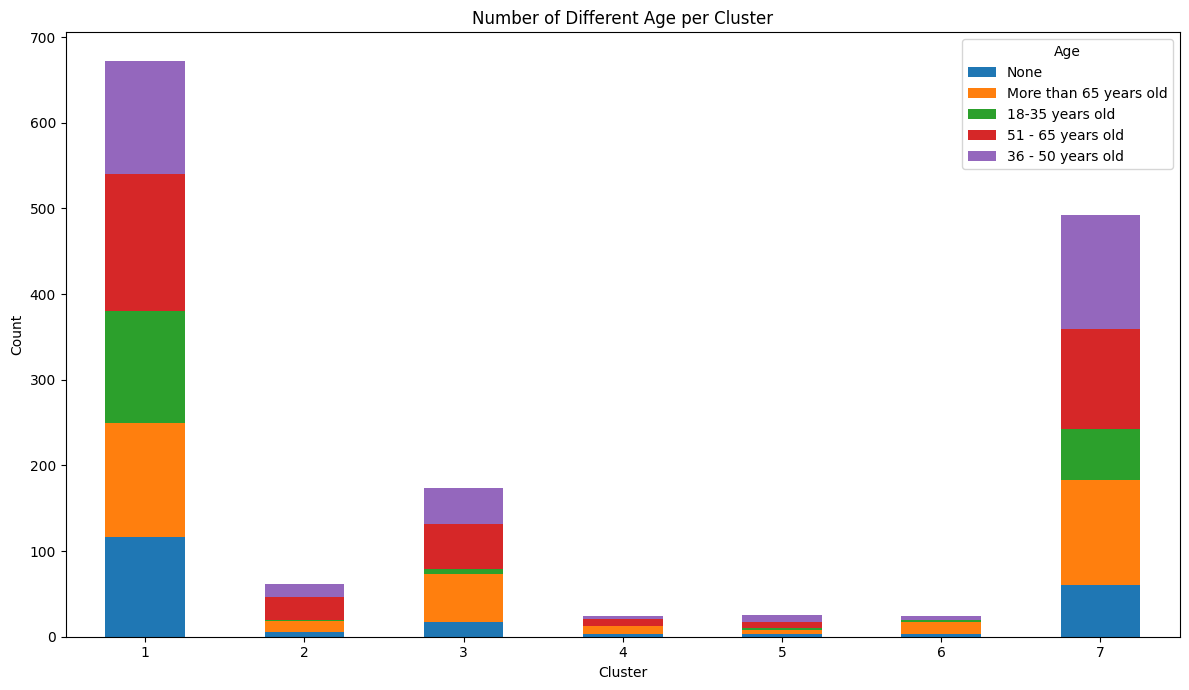

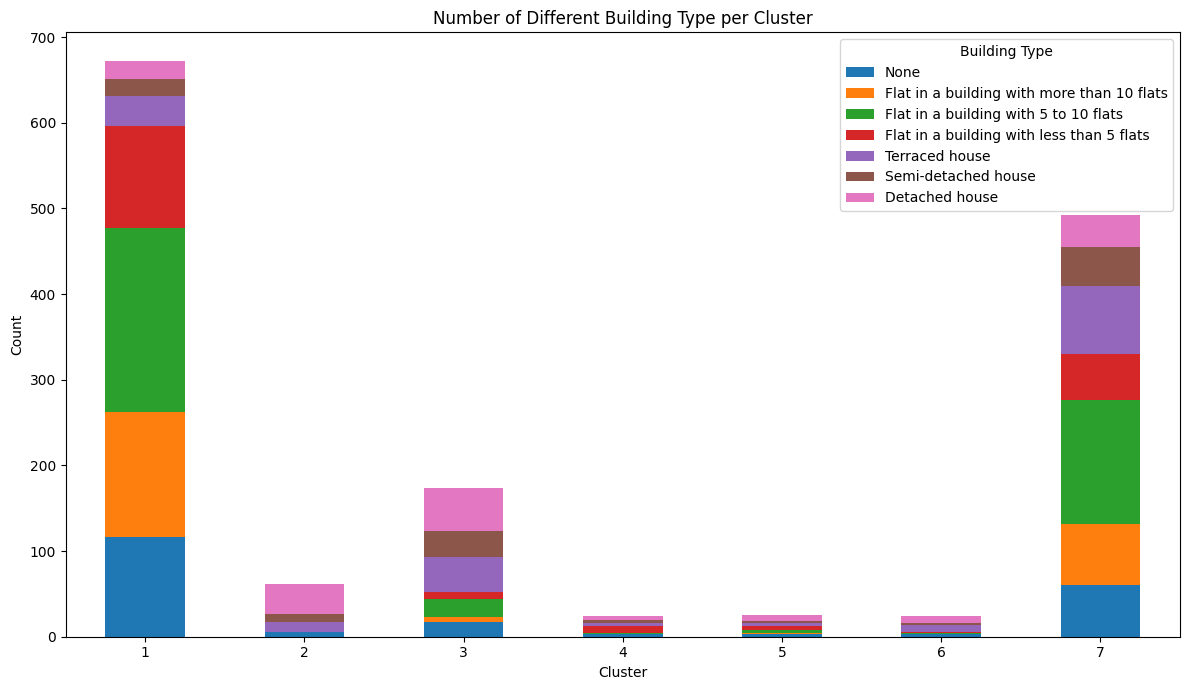

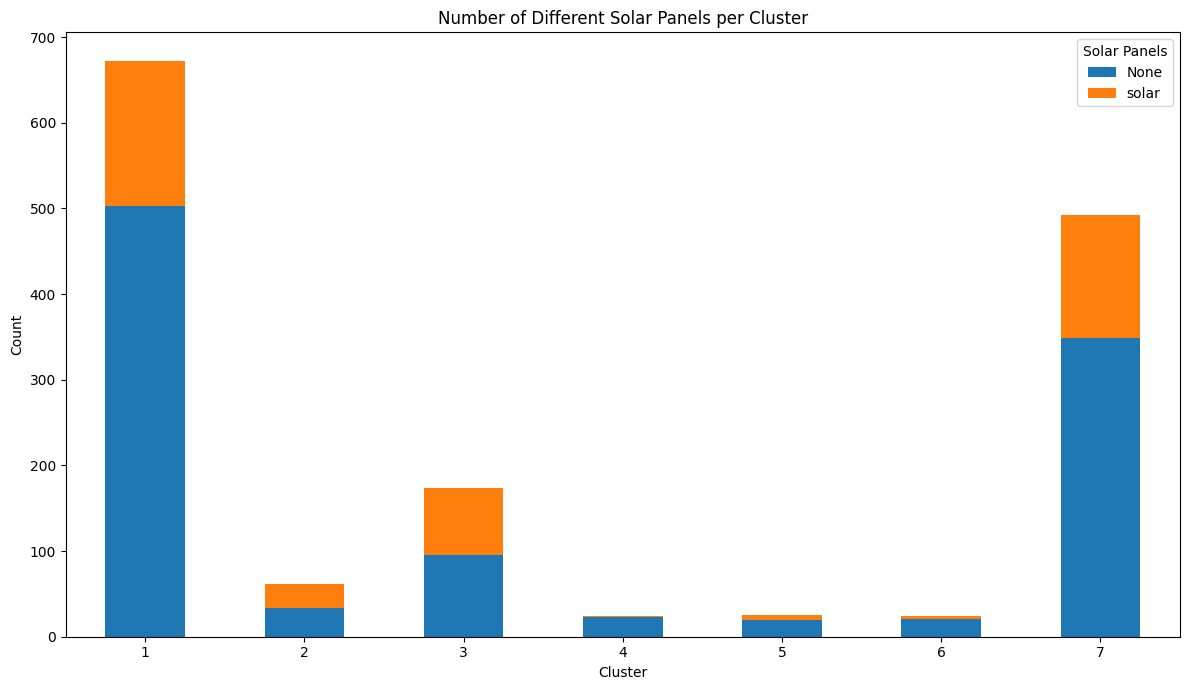

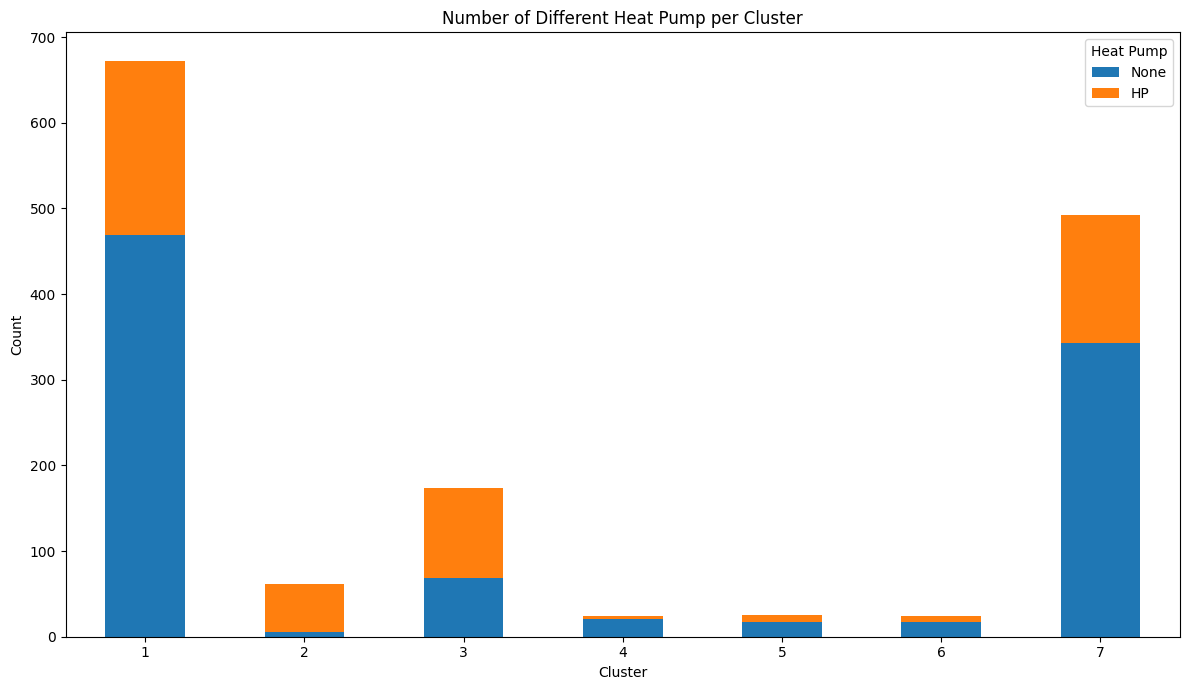

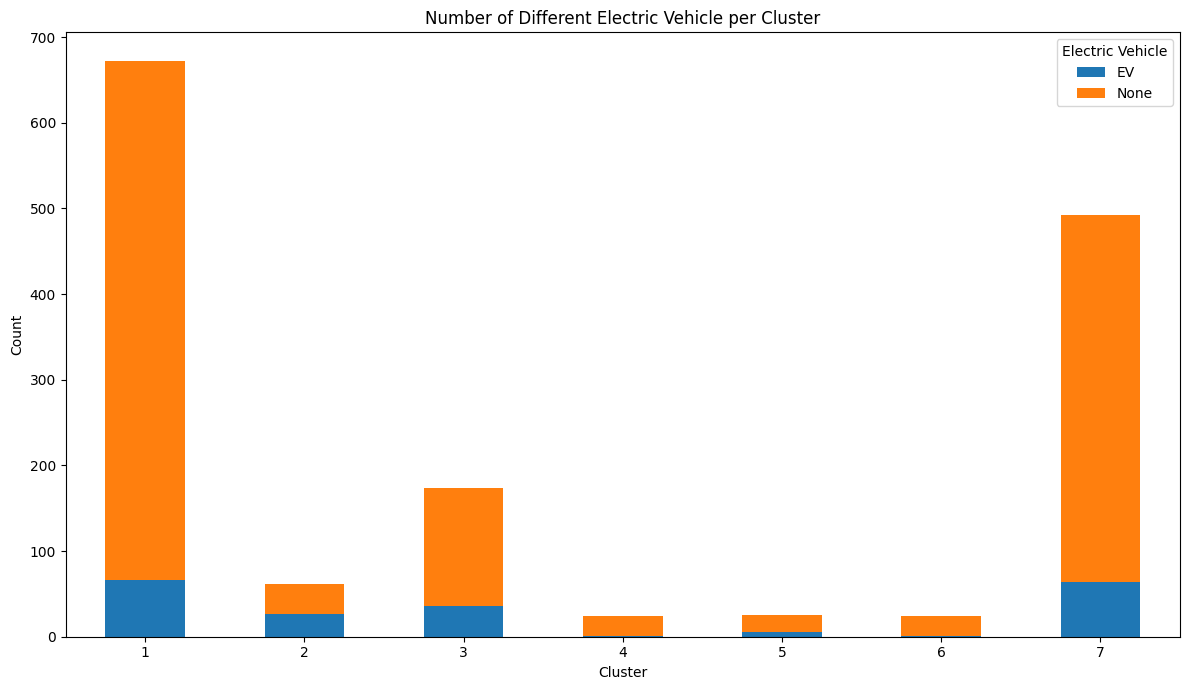

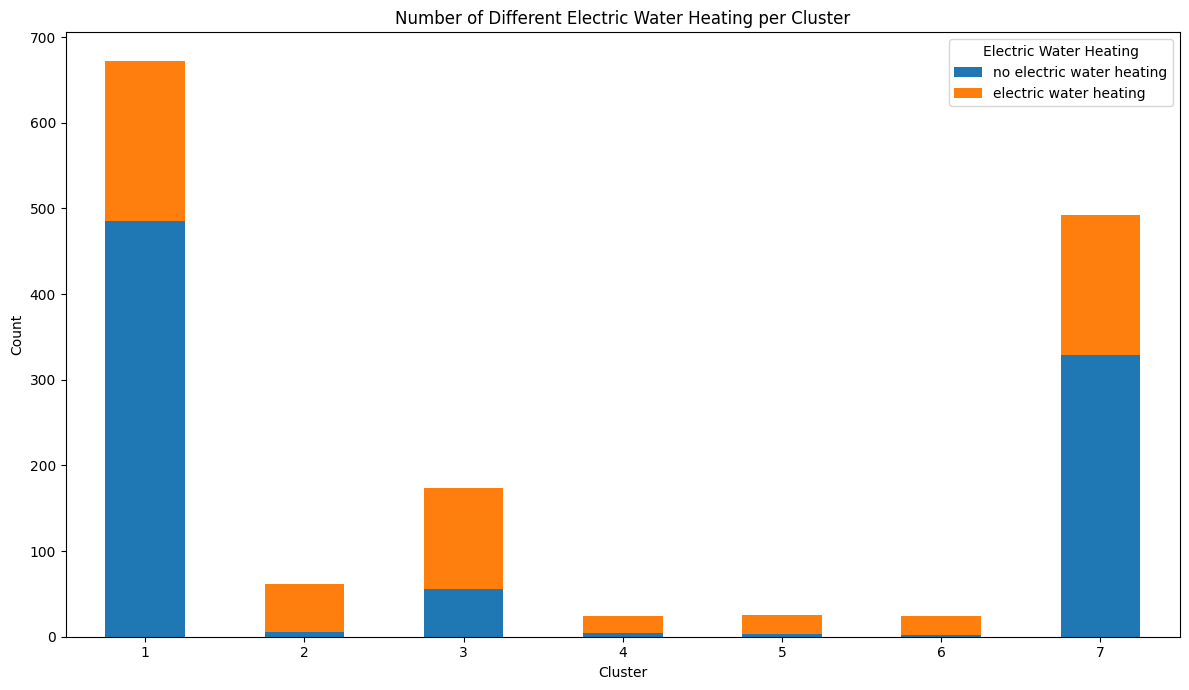

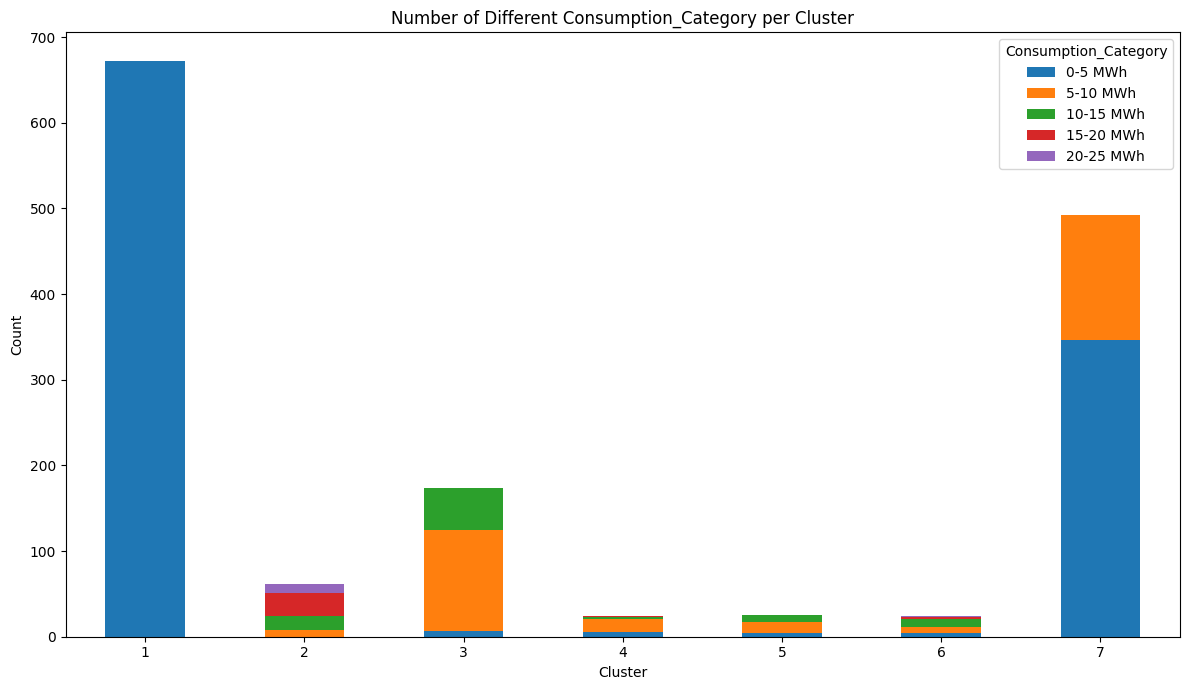

In [40]:
final_df = final_df.to_pandas()

clusters = sorted(final_df['cluster'].unique())

# Start from the second column, exclude 'cluster' explicitly
cols = final_df.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

for col in category_columns:
    final_df[col] = final_df[col].astype(str)
    categories = final_df[col].unique()
    counts = {cat: [] for cat in categories}

    for cl in clusters:
        cluster_subset = final_df[final_df['cluster'] == cl]
        for cat in categories:
            count_cat = sum(cluster_subset[col] == cat)
            counts[cat].append(count_cat)

    count_df = pd.DataFrame(counts, index=clusters)

    ax = count_df.plot(kind='bar', stacked=True, figsize=(12, 7))
    ax.set_title(f"Number of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=col.title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



In [40]:
final_df = final_df.to_pandas()
clusters = sorted(final_df['cluster'].unique())
# Start from the second column, exclude 'cluster' explicitly
cols = final_df.columns[1:]
category_columns = [col for col in cols if col != 'cluster']
for col in category_columns:
    final_df[col] = final_df[col].astype(str)
    categories = final_df[col].unique()
    counts = {cat: [] for cat in categories}
    for cl in clusters:
        cluster_subset = final_df[final_df['cluster'] == cl]
        for cat in categories:
            count_cat = sum(cluster_subset[col] == cat)
            counts[cat].append(count_cat)
    count_df = pd.DataFrame(counts, index=clusters)
    ax = count_df.plot(kind='bar', stacked=False, figsize=(12,7))
    ax.set_title(f"Number of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=col.title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



AttributeError: 'DataFrame' object has no attribute 'to_pandas'